In [1]:
import sys, os
sys.path.append('..')
sys.path.append('.')

import yaml

from absl import logging
import IPython
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import tensorflow as tf
import ddsp.colab.colab_utils
from ddsp.spectral_ops import compute_mel, compute_logmel
import ddsp.training
import gin
import gin.tf
import gin.tf.external_configurables

#import wandb
#resume = False
#wandb_id = 'placeholder'
logging.set_verbosity(logging.INFO)

gin.external_configurable(tf.keras.regularizers.L1, module='tf.keras.regularizers')

# Imports for regnet
# import math
# import os
# import random
# import shutil
# import time

# import torch
# from torch import nn
# from torch.utils.data import DataLoader
# from Recorder import Recorder
# from data_utils import RegnetLoader, get_TSN_Data_set
# from criterion import RegnetLoss
# from model import Regnet, Modal_Response_Net
# # from test import test_checkpoint
# from contextlib import redirect_stdout
# from config import _C as config
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
# from tqdm import tqdm

/juno/u/jyau/anaconda3/envs/diffimpactenv/lib/python3.8/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


tensorflow.python.keras.regularizers.L1

In [2]:
# Eval with saved tensors
def generate_audio_testing(raw_gain, raw_freq, raw_dampings, modal_fir, reverb, impulse_profile,
                           gains, frequencies, dampings, modal_response,
                           noise, acceleration_scale, revc, audio_sample_rate, example_secs, scratch='controls'):
    """Generate DiffImpact's estimate of impact sound based on current model variables."""
    # Generate impulse --> impact profile
    # magnitude_envelopes, taus, prediction['stdevs']
#     impc = impact.get_controls(mags, stdevs, taus, 0) # needs to be 2D?
#     impulse_profile = impact.get_signal(impc['magnitudes'], impc['taus'])
    print("impulse profile shape: ", impulse_profile.shape) # force profile
    zero_freq = np.zeros_like(raw_freq)
    zero_gain = np.random.rand(1,256) #np.zeros_like(raw_gain)
    zero_damp = np.zeros_like(raw_dampings)
    
#     vid = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-glass-bowl-10-of-47'
#     raw_gain = np.load(os.path.join(freq_path, vid+"_gains_raw.npy"))
#     raw_freq = np.load(os.path.join(freq_path, vid+"_freqs_raw.npy"))
#     raw_dampings = np.load(os.path.join(freq_path, vid+"_dampings_raw.npy"))
    
    # Get modal response from raw freqs, gains, and dampings
    irc_scratch = modal_fir.get_controls(raw_gain, raw_freq, raw_dampings)
    ir_scratch = modal_fir.get_signal(irc_scratch['gains'], irc_scratch['frequencies'], irc_scratch['dampings'])
    
    # Get modal response from scaled (passed through get_controls) freqs, gains, dampings
    ir = modal_fir.get_signal(gains, frequencies, dampings)
    
    print("ir: ", ir)
    print("model's output modal response: ", modal_response)
    #print("ir_scratch: ", ir_scratch)
    # Convolve together for modal vibration sounds
    if scratch == 'raw':
        audio = ddsp.core.fft_convolve(impulse_profile, ir_scratch)
    elif scratch == 'controls' or scratch =='control':
        audio = ddsp.core.fft_convolve(impulse_profile, ir)
    else:
        audio = ddsp.core.fft_convolve(impulse_profile, modal_response)
    print("convolved shape: ", audio.shape)
    
    # Generate and add time constant noise
    # Note that in the context, clips.shape[0] is batch size (which is 1 for all testing here)
    # clips.shape[1] is the actual clip size (like 441000 for 10 seconds of 44100 audio sampling rate)
    #unfiltered_noise = tf.random.uniform((clips.shape[0], int(clips.shape[1] * sample_factor)),
    #minval=-1.0, maxval=1.0)
    #noise = ddsp.core.frequency_filter(unfiltered_noise, ddsp.core.exp_sigmoid(noise_magnitudes - 4.0), 257)
    audio += noise
    print("after adding noise: ", audio.shape)
    
    # Add acceleration sound
    audio += impulse_profile * acceleration_scale
    print("after acceleration sound: ", audio.shape)
    
    # Add reverb
#     revc = reverb.get_controls(audio, reverb_gains, reverb_decay)
    audio = reverb.get_signal(audio, revc)#revc['ir'])
    print("after reverb: ", audio.shape)
    
    # Downsample from internal sampling rate to original recording sampling rate
    # audio = ddsp.core.resample(audio, clips.shape[1], 'linear')
    # Note that the resample function will return shape [n_timesteps], which is the second parameter
    print("audio sample rate: ", audio_sample_rate)
    audio = ddsp.core.resample(audio, int(audio_sample_rate)*example_secs, 'linear')
    return audio

In [18]:
# Use this method!!!!!
def generate_audio(predictions, modal_fir, reverb, impulse_profile, gains, frequencies, dampings, modal_response,
                   noise, acceleration_scale, revc, audio_sample_rate, example_secs, scratch='controls',
                   modal_fir_only=True):
    """Generate DiffImpact's estimate of impact sound based on current model variables."""
    # Generate impulse --> impact profile
    # magnitude_envelopes, taus, prediction['stdevs']
#     impc = impact.get_controls(mags, stdevs, taus, 0) # needs to be 2D
#     impulse_profile = impact.get_signal(impc['magnitudes'], impc['taus'])
    print("impulse profile shape: ", impulse_profile.shape) # force profile
    
    # Generate modal FIR --> modal response (object material sound)
    # TODO: To use "raw" normally again, make sure to switch this!!
    irc_scratch = modal_fir.get_controls(predictions['gains'], predictions['frequencies'], predictions['dampings'])
    ir_scratch = modal_fir.get_signal(irc_scratch['gains'], irc_scratch['frequencies'], irc_scratch['dampings'])
    #ir = modal_fir.get_signal(irc['gains'], irc['frequencies'], irc['dampings'])# Modal response
    ir = modal_fir.get_signal(gains, frequencies, dampings)
    print("ir: ", ir)
    print("model's output modal response: ", modal_response)
    print("ir_scratch: ", ir_scratch)
    # Convolve together for modal vibration sounds
    if scratch == 'raw':
        audio = ddsp.core.fft_convolve(impulse_profile, ir_scratch)
    elif scratch == 'controls':
        audio = ddsp.core.fft_convolve(impulse_profile, ir)
    else:
        audio = ddsp.core.fft_convolve(impulse_profile, modal_response)
    print("convolved shape: ", audio.shape)
    
    if modal_fir_only:
        print("Return audio without adding noise, acceleration sound, or reverb")
        audio = ddsp.core.resample(audio, int(audio_sample_rate)*example_secs, 'linear')
        return audio
    
    # Generate and add time constant noise
    # Note that in the context, clips.shape[0] is batch size (which is 1 for all testing here)
    # clips.shape[1] is the actual clip size (like 441000 for 10 seconds of 44100 audio sampling rate)
    #unfiltered_noise = tf.random.uniform((clips.shape[0], int(clips.shape[1] * sample_factor)), minval=-1.0, maxval=1.0)
    #noise = ddsp.core.frequency_filter(unfiltered_noise, ddsp.core.exp_sigmoid(noise_magnitudes - 4.0), 257)
    audio += noise
    print("after adding noise: ", audio.shape)
    
    # Add acceleration sound
    audio += impulse_profile * acceleration_scale
    print("after acceleration sound: ", audio.shape)
    
    # Add reverb
#     revc = reverb.get_controls(audio, reverb_gains, reverb_decay)
    audio = reverb.get_signal(audio, revc)#revc['ir'])
    print("after reverb: ", audio.shape)
    
    # Downsample from internal sampling rate to original recording sampling rate
    # audio = ddsp.core.resample(audio, clips.shape[1], 'linear')
    # Note that the resample function will return shape [n_timesteps], which is the second parameter
    print("audio sample rate: ", audio_sample_rate)
    audio = ddsp.core.resample(audio, int(audio_sample_rate)*example_secs, 'linear')
    return audio

INFO:absl:Loaded checkpoint /juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/multiclass-1hr/ckpt-9000
INFO:absl:Loading model took 0.0 seconds


Latest operative config used:  /juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/multiclass-1hr/operative_config-0.gin
n modal frequencies: 256
-4
4.0
/juno/u/jyau/regnet/data/features/ASMR/orig_asmr_by_material_clips/audio_10s_44100hz_ddsp/1hr/*/val/*.wav
Z time steps: 2520
Input key to EmbeddingContextEncoder: material_id
Output key to EmbeddingContextEncoder: material_embedding
audio shape:  tf.Tensor([], shape=(0,), dtype=int32)
decoded audio first shape:  (441344, 1)
(1, 441000)
audio sample_rate:  tf.Tensor(44100, shape=(), dtype=int32)
input to the model:  <BatchDataset shapes: {audio: (None, 441000), material_id: (None,), video_id: (None,)}, types: {audio: tf.float32, material_id: tf.int32, video_id: tf.int32}>


number of inputs to z encoder:  1
keyword arguments:  {'training': False}
Computing mfccs and latent z from audio:  (1, 441000)
sample rate: 44100, bin: 128, fft_size: 1024, overlap: 0.75
matrix of mag from compute_mel:  tf.Tensor(
[[[8.51276983e-03 5.95560111e-03 2.74472358e-03 ... 1.69821215e-04
   3.13580153e-04 5.67426905e-05]
  [5.98987564e-04 1.01710455e-02 2.43567652e-03 ... 2.64861126e-04
   1.64231911e-04 1.43121957e-04]
  [3.07465140e-02 2.73855459e-02 1.41652292e-02 ... 2.56147527e-04
   1.86664165e-05 1.01979822e-05]
  ...
  [1.18910121e-02 5.20539749e-03 1.08683705e-02 ... 2.85401784e-05
   1.25499777e-04 2.17544846e-04]
  [7.54204579e-03 7.64812389e-03 7.61509174e-03 ... 5.38899840e-05
   8.44566457e-05 9.83627979e-05]
  [1.05746905e-03 1.03977812e-03 9.88010201e-04 ... 1.05925983e-05
   1.15979483e-05 1.19797769e-05]]], shape=(1, 1723, 513), dtype=float32)
matrix of mel from compute_mel:  tf.Tensor(
[[[0.         0.00476286 0.00119274 ... 0.00116538 0.00122963 0.0012772 

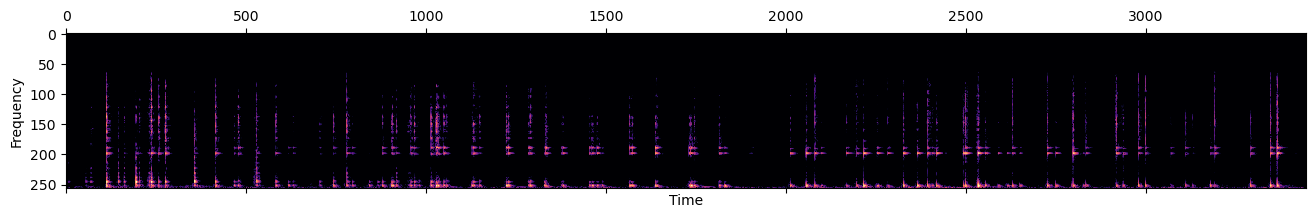

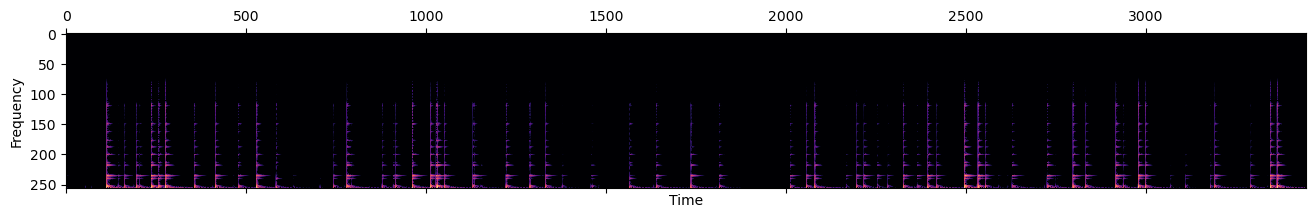

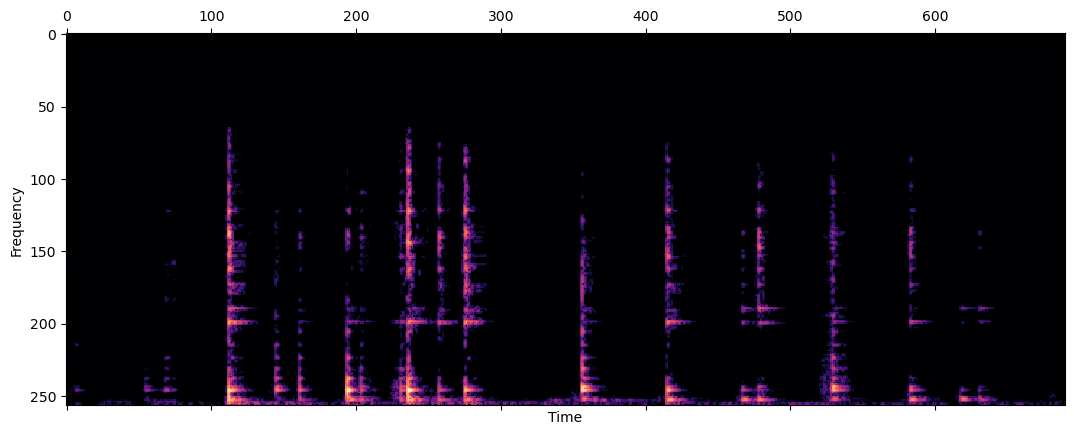

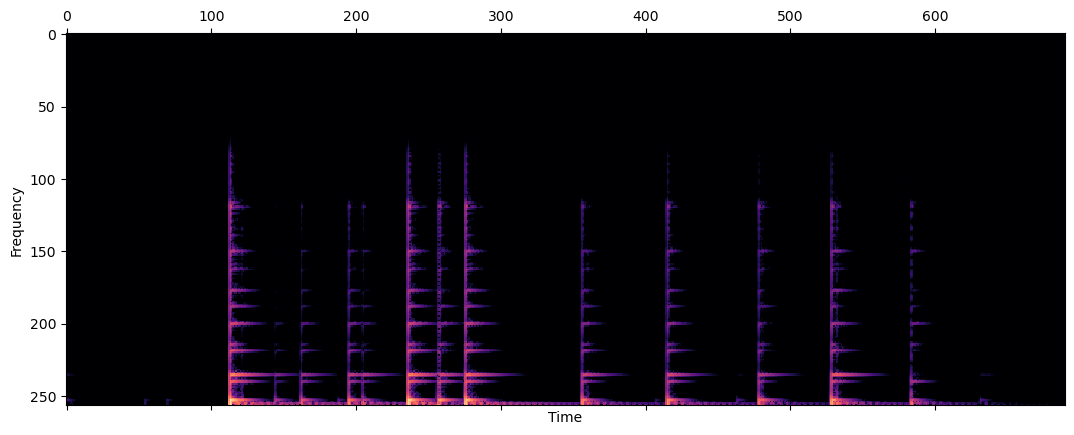

Output synth of the checkpoint from prediction[audio_synth]


input shapes! impulse_profile: (1, 882000), ir: (1, 176400), noise: (1, 882000), revc: (1, 48000)


TypeError: generate_audio() got an unexpected keyword argument 'modal_fir_only'

In [17]:
# Test out the N_MODAL_FREQUENCIES=256 checkpoint for multiclass checkpoint
from IPython.display import display

# Path to eval output
#eval_output = "/juno/u/jyau/regnet/ckpt/visual_extract_pipeline_rgb_only/checkpoint_075000/eval_output"
# Full pipeline
voc_type = "glass-bowl" #"wooden-box" # wood-box
vocoder_type = 'glass-bowl'
save_dir = f'/juno/u/jyau/asmr-video-to-sound/ddsp/diffimpact/asmr/ckpt/multiclass-1hr/'
# save_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/asmr/regnet-labels/1hr-{vocoder_type}'
# save_dir = f'/juno/u/jyau/regnet/ddsp/diffimpact/checkpoints/{voc_type}' # Sam's checkpoint
# save_dir = '/juno/u/jyau/regnet/ddsp/diffimpact/asmr/regnet-labels/train-all'
example_secs = 10
offset_secs = 0

#latest_operative_config = ddsp.training.train_util.get_latest_operative_config(save_dir)
latest_operative_config = os.path.join(save_dir, 'operative_config-0.gin')
gin.parse_config_file(latest_operative_config)
print("Latest operative config used: ", latest_operative_config)

n_modal_freq = gin.config.query_parameter('%N_MODAL_FREQUENCIES')
print(f"n modal frequencies: {n_modal_freq}")
#gin.config.bind_parameter('%N_MODAL_FREQUENCIES', 64)
#n_modal_freq = gin.config.query_parameter('%N_MODAL_FREQUENCIES')
#print(f"n modal frequencies: {n_modal_freq}")

train_sample_rate = gin.config.query_parameter('%AUDIO_SAMPLE_RATE')
train_samples = gin.config.query_parameter('%N_AUDIO_SAMPLES')

audio_sample_rate = train_sample_rate

train_z_steps = gin.config.query_parameter('MfccTimeDistributedRnnEncoder.z_time_steps')
offset_samples = int(offset_secs * train_sample_rate)
test_samples = int(example_secs * train_sample_rate)

test_z_steps = int(example_secs / (train_samples / train_sample_rate) * train_z_steps)
gin.config.bind_parameter('%N_AUDIO_SAMPLES', test_samples)
try:
    train_internal_sample_rate = gin.config.query_parameter('%INTERNAL_SAMPLE_RATE')
    test_internal_samples = int(example_secs * train_internal_sample_rate)
    gin.config.bind_parameter('%INTERNAL_AUDIO_SAMPLES', test_internal_samples)
    gin.config.bind_parameter('FilteredNoise.initial_bias', gin.config.query_parameter('FilteredNoise.initial_bias') - 1.0)
except ValueError:
    pass
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias', -4)
gin.config.bind_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias', 4.0)
gin.config.bind_parameter('MfccTimeDistributedRnnEncoder.z_time_steps', test_z_steps)
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.gain_initial_bias'))
print(gin.config.query_parameter('FilteredNoiseExpDecayReverb.decay_initial_bias'))
print(gin.config.query_parameter('%VALIDATION_FILE_PATTERN'))

model = ddsp.training.models.get_model()
model.restore(save_dir)

# Loading and processing audio
MAX_WAV_VALUE = 32768.0

# audio_title = vid
#audio_title = "The_Ultiimate_Tapping_ASMR_3_Hours_No_Talking-plastic-mold-2-16-of-18"
audio_title = 'ASMR_Addictive_Tapping_1_Hr_No_Talking-glass-bowl-34-of-47'
# audio_title = "ASMR_Addictive_Tapping_1_Hr_No_Talking-wooden-box-27-of-45"
#audio = tf.io.read_file('/juno/u/spclarke/asmr_data/tapping/materials/valid/sIgkTYTWPz8-004-0000.wav')
#audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
try:
    audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/orig_asmr_by_material_clips/audio_10s_44100hz_ddsp/1hr/{vocoder_type}/train/{audio_title}.wav')
except Exception as ex:
    audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/orig_asmr_by_material_clips/audio_10s_44100hz_ddsp/1hr/{vocoder_type}/val/{audio_title}.wav')
# audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/ASMR_Brain_3D_Tapping/audio_10s_44100hz/{audio_title}.wav')
#compare_audio = tf.io.read_file(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/audio_ori/{audio_title}.wav')
# Ground truth
#orig_audio = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/asmr_both_vids/melspec_10s_44100hz/{audio_title}_audio.npy')
#audio = np.load(f"/juno/u/jyau/regnet/ckpt/asmr_full/inference_test/{audio_title}.npy")

print("audio shape: ", tf.shape(audio))
decoded_audio_init, audio_sample_rate = tf.audio.decode_wav(audio, desired_channels=1)
print("decoded audio first shape: ", decoded_audio_init.shape)

#decoded_audio = decoded_audio * # Test by inputting zero vector audio
decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio_init[offset_samples:(offset_samples + test_samples)]), axis=0)
#decoded_audio = tf.expand_dims(tf.squeeze(decoded_audio), axis=0)
print(decoded_audio.shape)
print("audio sample_rate: ", audio_sample_rate)
test_input = tf.data.Dataset.from_tensor_slices({'audio':decoded_audio, 'material_id':[0], 'video_id':[0]}).batch(2)
print("input to the model: ", test_input)
display(IPython.display.Audio(data=decoded_audio, rate=int(train_sample_rate)))

# audio of length of around 0.5 seconds (22050/256= 86 .1) for audio sampling rate 44100 and hop length 256
# Note that Sam's model uses mel_bins=128!
prediction = model(next(iter(test_input)), training=False)
print("pred audio shape: ", prediction['audio'].shape)
print("pred audio synth shape: ", prediction['audio_synth'].shape)
# ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :]*MAX_WAV_VALUE, size=512)
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :], size=512)
# ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2]*MAX_WAV_VALUE, size=512)
ddsp.colab.colab_utils.specplot(prediction['audio'][:1, :train_sample_rate*2], size=512)
ddsp.colab.colab_utils.specplot(prediction['audio_synth'][:1, :train_sample_rate*2], size=512)
plt.show()

print("Output synth of the checkpoint from prediction[audio_synth]")
display(IPython.display.Audio(data=prediction['audio_synth'][:1, :], rate=int(train_sample_rate)))
# IPython.display.Audio(data=prediction['modal_fir']['signal'][:1, :], rate=int(audio_sample_rate))

# Generate audio by replacing the frequency with eval
# Initialize modules
sample_factor = 2
modal_fir = ddsp.synths.ModalFIR(n_samples=int(sample_factor * train_sample_rate), sample_rate=int(sample_factor * train_sample_rate),
                            initial_bias=-1.5, hz_max=20000.0, freq_scale_fn=ddsp.core.frequencies_critical_bands, freq_scale='mel')
impact = ddsp.synths.Impact(sample_rate=int(sample_factor * audio_sample_rate), n_samples=int(sample_factor), max_impact_frequency=20, mag_scale_fn=ddsp.core.exp_sigmoid, include_noise=True)
reverb = ddsp.effects.FilteredNoiseExpDecayReverb(trainable=False, reverb_length=int(48000 * sample_factor), decay_initial_bias=4.0, add_dry=True)

acceleration_scale = prediction['acceleration_scalar']
impulse_profile = prediction['impact']['signal']
ir = prediction['modal_fir']['signal'] # modal response
noise = prediction['filtered_noise']['signal']
revc = prediction['reverb']['controls']['ir'] #np.concatenate((np.zeros(begin_offset), np.squeeze(prediction['reverb']['controls']['ir'])))

print(f"input shapes! impulse_profile: {impulse_profile.shape}, ir: {ir.shape}, noise: {noise.shape}, revc: {revc.shape}")

audio_final = generate_audio(prediction, modal_fir, reverb, impulse_profile,
                             prediction['modal_fir']['controls']['gains'],
                             prediction['modal_fir']['controls']['frequencies'],
                             prediction['modal_fir']['controls']['dampings'],
                             ir, noise, acceleration_scale, revc, audio_sample_rate, example_secs, scratch='raw',
                             modal_fir_only=True)

print(f"final audio shape: {audio_final.shape} compared to audio_synth shape: {prediction['audio_synth'].shape}")
display(IPython.display.Audio(data=audio_final, rate=int(train_sample_rate)))

In [12]:
# Get modal response with the audio dspy library
import audio_dspy as adsp
mel = np.load(f'/juno/u/jyau/regnet/data/features/ASMR/orig_asmr_by_material_clips/melspec_10s_44100hz/{vid}_mel.npy')
print(f'mel shape: {mel.shape} and audio sample rate: {audio_sample_rate}')
freqs, gains = adsp.find_freqs(decoded_audio_init, audio_sample_rate, plot=True)

obj = {}
obj['frequencies'] = freqs
obj['gains'] = gains
obj['dampings'] = prediction['dampings']

# Generate modal response, and convolve with the force profile, noise, and reverb
print(f"freqs: {freqs.shape}, gains: {gains.shape}, damping: {prediction['dampings'].shape} noise: {noise.shape}, revc: {revc.shape}")
audio_final = generate_audio(obj, modal_fir, reverb, impulse_profile,
                             prediction['modal_fir']['controls']['gains'],
                             prediction['modal_fir']['controls']['frequencies'],
                             prediction['modal_fir']['controls']['dampings'],
                             ir, noise, acceleration_scale, revc, audio_sample_rate, example_secs, scratch='raw')
print(f"final audio shape: {audio_final.shape} compared to audio_synth shape: {prediction['audio_synth'].shape}")
display(IPython.display.Audio(data=audio_final, rate=int(train_sample_rate)))

mel shape: (80, 1720) and audio sample rate: 44100


/juno/u/jyau/anaconda3/envs/diffimpactenv/lib/python3.8/site-packages/audio_dspy/modal_tools.py:43: RuntimeWarning: divide by zero encountered in log10
  Mag = 20 * np.log10(np.abs(X[k]))


freqs: (0,), gains: (0,), damping: (1, 256) noise: (1, 882000), revc: (1, 48000)
impulse profile shape:  (1, 882000)


/juno/u/jyau/anaconda3/envs/diffimpactenv/lib/python3.8/site-packages/audio_dspy/modal_tools.py:73: RuntimeWarning: divide by zero encountered in log10
  plt.semilogx(f, 20 * np.log10(np.abs(X)))


IndexError: tuple index out of range

In [ ]:
scratch = 'else'
# Generate modal FIR --> modal response (object material sound)
modal_response = prediction['modal_fir']['signal']
irc_scratch = modal_fir.get_controls(prediction['gains'], prediction['frequencies'], prediction['dampings'])
ir_scratch = modal_fir.get_signal(irc_scratch['gains'], irc_scratch['frequencies'], irc_scratch['dampings'])
#ir = modal_fir.get_signal(irc['gains'], irc['frequencies'], irc['dampings'])# Modal response
ir = modal_fir.get_signal(prediction['modal_fir']['controls']['gains'],
                          prediction['modal_fir']['controls']['frequencies'],
                          prediction['modal_fir']['controls']['dampings'])
print("ir: ", ir)
print("model's output modal response: ", modal_response)
print("ir_scratch: ", ir_scratch)
# Convolve together for modal vibration sounds
# Convolve together for modal vibration sounds
if scratch == 'raw':
    audio = ddsp.core.fft_convolve(impulse_profile, ir_scratch)
elif scratch == 'controls':
    audio = ddsp.core.fft_convolve(impulse_profile, ir)
else:
    audio = ddsp.core.fft_convolve(impulse_profile, modal_response)
print("convolved shape: ", audio.shape)

# Generate and add time constant noise
audio += noise
print("after adding noise: ", audio.shape)

# Add acceleration sound
audio += impulse_profile * acceleration_scale
print("after acceleration sound: ", audio.shape)

# Add reverb
audio = reverb.get_signal(audio, revc)#revc['ir'])
print("after reverb: ", audio.shape)

# Downsample from internal sampling rate to original recording sampling rate
print("audio sample rate: ", audio_sample_rate)
audio = ddsp.core.resample(audio, int(audio_sample_rate)*example_secs, 'linear')
display(IPython.display.Audio(data=audio, rate=int(train_sample_rate)))

In [ ]:
# TODO: only after merging the regnet and ddsp models, otherwise they're using two different envs currently
# Load the trained frequency decoder model
# model = Modal_Response_Net()
# print("Initialized model")

# model.load_checkpoint(config.checkpoint_path)

# # Load data
# print("Getting the images to be stacked...")
# args.test_list = './filelists/asmr_by_material_1hr_train.txt' 
# trainset = get_TSN_Data_set(args)
# args.test_list = './filelists/asmr_by_material_1hr_test.txt'
# valset = get_TSN_Data_set(args)

# train_loader = DataLoader(trainset, num_workers=0, shuffle=True,
#                           batch_size=config.batch_size, pin_memory=False,
#                           drop_last=True)
# test_loader = DataLoader(valset, num_workers=0, shuffle=False,
#                          batch_size=config.batch_size, pin_memory=False)
# print("Check number of train examples: ", len(trainset))
# print("Check number of train loader examples: ", len(train_loader))
# assert(len(trainset) > 0)
# assert(len(train_loader) > 0)

In [ ]:
# SpecGAN Vladimir evaluated sample check
mel_check = np.load('/juno/u/jyau/SpecVQGAN/logs/2021-12-11T17-05-22_asmr_by_material_transformer/samples_None/VAS_validation/cls_1/ASMR_Addictive_Tapping_1_Hr_No_Talking-ceramic-plate-38-of-41_mel_sample_0.npy')
print(mel_check.shape)
ddsp.colab.colab_utils.specplot(mel_check, size=512)

plt.figure()
plt.imshow(mel_check,aspect='auto', origin='lower')
plt.show()
#display(IPython.display.Audio(data=check, rate=int(44100)))